# Stock price prediction challenge

We'll be using RNN (LSTM) to predict time-series, with the specific goal of forecasting stock price action.


### First steps
We must load a time series to begin our work. We'll be using 140 day Apple stock price. Also, we will need to preprocess data to be able to feed it to a RNN model. 

First, we'll normalize the range of the series, to avoid large numerical problemas associated with neuron activation functions like tanh on very large numbers. This also helps avoiding problems in the calculation of derivatives needed for gradient descent. The series is normalized to belong to the range [-1,1] using MinMaxScaler.

In [ ]:
### Loading needing libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Cloning git repo with data
! git clone https://bitbucket.org/botiaio/campusparty_applestock.git

Cloning into 'campusparty_applestock'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 1.77 KiB | 1.77 MiB/s, done.


In [ ]:
### Load normalized data
dataset = np.loadtxt('campusparty_applestock/normalized_apple_prices.csv')

In [ ]:
## Quick data shape and lenght analysis 
print(f'El dataset tiene un tamaño de {dataset.shape}')
print(f'Los primeros 5 valores son: {dataset[0:5]}')

El dataset tiene un tamaño de (138,)
Los primeros 5 valores son: [-0.70062339 -0.82088484 -0.93938305 -0.9471652  -0.68785527]


 ### Plotting loaded data

Text(0, 0.5, 'serie normalizada')

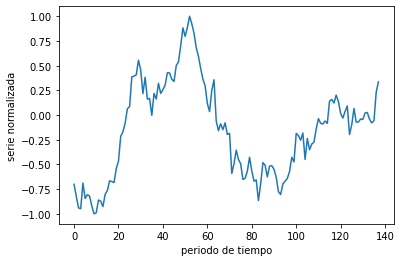

In [ ]:
#Grafiquemos los datos
plt.plot(dataset)
plt.xlabel('periodo de tiempo')
plt.ylabel('serie normalizada')

### Crop ordered series into sequences 


An ordered series is usually represented mathematically as:

$$s_{0},s_{1},s_{2},...,s_{P}$$


where $s_{p}$ is the numerical value of the series at time interval $p$ , where $P$ is the total length of the series. To apply the RNN one must treat the prediction as a regression problem. To do so, a sliding window must be used to construct an associated set of input-output pairs on which to apply the regression.

For example, for a window of size T = 3 the following pairs should be produced:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3}\rangle} & \color{Goldenrod}{ s_{4}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4} \rangle } & \color{Goldenrod} {s_{5} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

In [ ]:
def window_transform_series(series,window_size):
    # variables para los pares input-output
    X = []
    y = []

    ### Se recomienda usar un for dentro de otro for aquí
    for i in range(len(series) - window_size):
      X.append(series[i:i+window_size])  # this would be input list
      y.append(series[i+window_size])    #this would be output (scalar, not list)

    # Código auxiliar que puede ser necesario
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

### Test window_transform_series function

In [ ]:
test_series = [1,2,3,4,5]

In [ ]:
window_size = 2
X,y = window_transform_series(test_series,window_size)

In [ ]:
print ('El input X es:')
print (X)

print ('El output y asociado es:')
print (y)

El input X es:
[[1 2]
 [2 3]
 [3 4]]
El output y asociado es:
[[3]
 [4]
 [5]]


Una vez que la función de arriba funcione correctamente, aplicarla con una ventana de tamaño 7 al juego de datos cargados.



In [ ]:
window_size = 7
X,y = window_transform_series(dataset,window_size)

### Split data into training and testing set

In [ ]:
# Separando los datos en entrenamiento y test
train_test_split = int(len(X)*0.7)

# Partir los datos
X_train = X[:train_test_split]
y_train = y[:train_test_split]

# Mantener la última parte para test
X_test = X[train_test_split:]
y_test = y[train_test_split:]

In [ ]:
##testeando que hayan quedado bien los X_train, y_train ...
print(f'La dimension de X_train es: {X_train.shape}')
print(f'La dimension de y_train es: {y_train.shape}')

print(f'La dimension de X_test es: {X_test.shape}')
print(f'La dimension de y_test es: {y_test.shape}')

La dimension de X_train es: (91, 7)
La dimension de y_train es: (91, 1)
La dimension de X_test es: (40, 7)
La dimension de y_test es: (40, 1)


Vemos que el tamaño es el adecuado, ya que dada nuestra ventana temporal de 7 y nuestro dataset de 138 muestras, tenemos 131 posibles pares input/output.

131 * 0.7 = 91.7 , int de eso es 91
De test tenemos 40, y 40+91 = 131 (el total de pares).

Es decir, construimos bien el split sin dejar datos afuera o superponer datos entre ambos datasets.

In [ ]:
# IMPORTANTE: para utilizar el módulo RNN LSTM de Keras el input debe tener la forma [samples, window size, stepsize]
#Estas transformaciones se hacen a continuación
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

### Create RNN model using LSTM modules

In [ ]:
# Importando librerías de Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

np.random.seed(42) ##defino una seed para reproducibilidad

#Crear el modelo secuencial
model = Sequential()
#Agregar una capa LSTM con 5 unidades ocultas y el input shape necesario
model.add(LSTM(5, input_shape=(window_size, 1)))
#Agregar una capa densa con una unidad
model.add(Dense(1, activation=None))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

# Compilar el modelo con la función de pérdida requerida
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
##Chequeamos el modelo con summary
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 5)                 140       
                                                                 
 dense_45 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model

history = model.fit(X_train, y_train, epochs=400, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 0.2665 - val_loss: 0.0276
Epoch 2/400
1/1 [==============================] - 0s 42ms/step - loss: 0.2463 - val_loss: 0.0250
Epoch 3/400
1/1 [==============================] - 0s 41ms/step - loss: 0.2270 - val_loss: 0.0239
Epoch 4/400
1/1 [==============================] - 0s 43ms/step - loss: 0.2088 - val_loss: 0.0240
Epoch 5/400
1/1 [==============================] - 0s 40ms/step - loss: 0.1913 - val_loss: 0.0248
Epoch 6/400
1/1 [==============================] - 0s 47ms/step - loss: 0.1744 - val_loss: 0.0258
Epoch 7/400
1/1 [==============================] - 0s 46ms/step - loss: 0.1578 - val_loss: 0.0265
Epoch 8/400
1/1 [==============================] - 0s 45ms/step - loss: 0.1416 - val_loss: 0.0266
Epoch 9/400
1/1 [==============================] - 0s 45ms/step - loss: 0.1258 - val_loss: 0.0260
Epoch 10/400
1/1 [==============================] - 0s 41ms/step - loss: 0.1106 - val_loss: 0.0250
Epoch 11/400
1/1 [===

### Performance check

In [ ]:
# Predicción con el modelo entrenado
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [ ]:
print(f'shape de train_predict : {train_predict[:].shape}')

shape de train_predict : (91, 1)


In [ ]:
# Medir la precisión
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Error de entrenamiento = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Error de test = ' + str(testing_error))

Error de entrenamiento = 0.014258435927331448
Error de test = 0.016299571841955185


Ahora grafiquemos los datos:

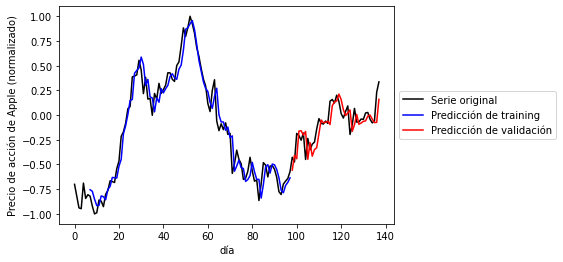

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Graficar serie original
plt.plot(dataset,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = train_test_split + window_size
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Apple (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Nota:[Aquí](https://datamarket.com/data/list/?q=provider%3Atsdl) se pueden encontrar otras series ordenadas con las que probar

In [ ]:
#testeemos sobre una serie temporal del stock de google que encontre
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

google = pd.read_csv('alpha_stock.txt')
google_price=google.iloc[:,1:2].values
sc = MinMaxScaler(feature_range = (-1, 1))
google_price_scaled = sc.fit_transform(google_price)

In [ ]:
google.head()

,Date,Open,High,Low,Close,Volume
0,11/26/2013,522.34,528.77,519.52,"1,055.51","4,589,600"
1,11/27/2013,529.03,532.01,528.02,"1,060.20","2,255,500"
2,11/29/2013,529.10,531.32,527.75,"1,056.69","2,394,400"
3,12/2/2013,529.77,531.18,523.42,"1,051.59","2,756,600"
4,12/3/2013,523.51,529.73,522.55,"1,050.38","3,364,700"


Text(0, 0.5, 'serie normalizada')

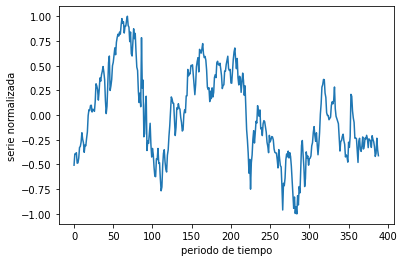

In [ ]:
#Grafiquemos los datos a ver si cargamos bien la serie temporal
plt.plot(google_price_scaled)
plt.xlabel('periodo de tiempo')
plt.ylabel('serie normalizada')

12/12 [==============================] - 0s 2ms/step
Error de test = 0.018539361655712128


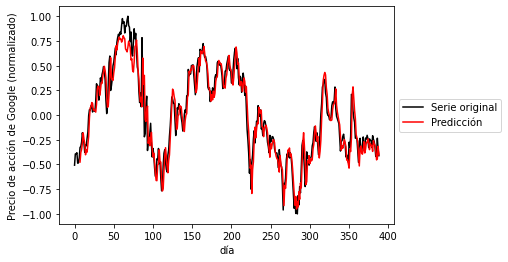

In [ ]:
window_size = 7
X_google, y_google = window_transform_series(google_price_scaled,window_size)
X_google = np.asarray(np.reshape(X_google, (X_google.shape[0], window_size, 1)))
y_google_predict = model.predict(X_google)

google_error = model.evaluate(X_google, y_google, verbose=0)
print('Error de test = ' + str(google_error))

import matplotlib.pyplot as plt
%matplotlib inline

# Graficar serie original
plt.plot(google_price_scaled,color = 'k')
plt.plot(np.arange(window_size,len(google_price_scaled),1),y_google_predict, color='r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Google (normalizado)')
plt.legend(['Serie original','Predicción'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Puntos de mejora

Realmente lo obtenido es resultado de un proceso iterativo, surge de probar
distintas combinaciones:
* mayor cantidad de unidades en la capa LSTM,
* mas capas LSTM concatenadas,
* utilizacion de regularización mediante Dropout,
* modificar el tamaño de la ventana temporal,
* testear distintas funciones de activación en la capa LSTM

Lo que mejor resultado obtuvo (aunque marginalmente) fue:
añadir una funcion de activacion Relu a la capa LSTM,
y variar el tamaño de la ventana temporal

Estaria bueno hacer una optimización de hiperparametros con esta
arquitectura, para ver si se pueden obtener leves mejroas.

Es probable que se puedan obtener mejores resultados con arquitecturas mas grandes (es decir con un mayor número de parámetros, i.e. más capas y más unidades por capas) pero para no caer en overfitting seria necesario tener
datasets de entrenamiento más grandes

In [ ]:


from keras.layers import Dropout


# Definir la variable window_size y usarla al invocar la función window_transform_series
window_size = 10
X_new,y_new = window_transform_series(dataset,window_size)

# Separar los datos en entrenamiento y test
train_test_split = int(len(X)*0.7)

# Partir los datos
X_train = X_new[:train_test_split]
y_train = y_new[:train_test_split]

# Mantener la última parte para test
X_test = X_new[train_test_split:]
y_test = y_new[train_test_split:]

X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

#Crear el modelo secuencial con mayor unidades en la capa LSTM
model2 = Sequential()
#Agregar una capa LSTM con 5 unidades ocultas y el input shape necesario
model2.add(LSTM(5, input_shape=(window_size, 1), activation='relu'))

#Agregar una capa densa con una unidad
model2.add(Dense(1, activation=None))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

# Compilar el modelo con la función de pérdida requerida
model2.compile(loss='mean_squared_error', optimizer=optimizer)
model2.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 5)                 140       
                                                                 
 dense_67 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#entrenamos antes de modificar la ventana temporal para ver los resultados
#de modificar solo ese parametro
history2 = model2.fit(X_train, y_train, epochs=400, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 0.1522 - val_loss: 0.0171
Epoch 2/400
1/1 [==============================] - 0s 49ms/step - loss: 0.1329 - val_loss: 0.0161
Epoch 3/400
1/1 [==============================] - 0s 65ms/step - loss: 0.1158 - val_loss: 0.0156
Epoch 4/400
1/1 [==============================] - 0s 44ms/step - loss: 0.0998 - val_loss: 0.0154
Epoch 5/400
1/1 [==============================] - 0s 46ms/step - loss: 0.0848 - val_loss: 0.0154
Epoch 6/400
1/1 [==============================] - 0s 53ms/step - loss: 0.0710 - val_loss: 0.0158
Epoch 7/400
1/1 [==============================] - 0s 42ms/step - loss: 0.0589 - val_loss: 0.0165
Epoch 8/400
1/1 [==============================] - 0s 43ms/step - loss: 0.0489 - val_loss: 0.0174
Epoch 9/400
1/1 [==============================] - 0s 41ms/step - loss: 0.0419 - val_loss: 0.0184
Epoch 10/400
1/1 [==============================] - 0s 44ms/step - loss: 0.0385 - val_loss: 0.0195
Epoch 11/400
1/1 [===

2/2 [==============================] - 0s 6ms/step
Error de entrenamiento = 0.015601410530507565
Error de test = 0.01410780381411314


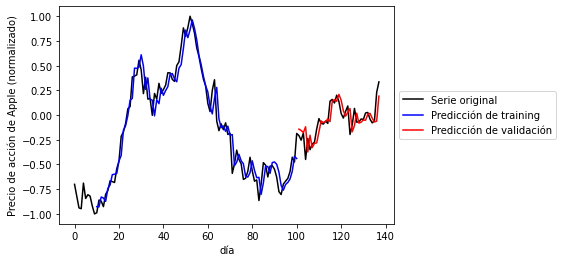

In [ ]:
# Hacer la predicción con el modelo entrenado
train_predict = model2.predict(X_train)
test_predict = model2.predict(X_test)

# Medir la precisión
training_error = model2.evaluate(X_train, y_train, verbose=0)
print('Error de entrenamiento = ' + str(training_error))

testing_error = model2.evaluate(X_test, y_test, verbose=0)
print('Error de test = ' + str(testing_error))

# Graficar serie original
plt.plot(dataset,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = train_test_split + window_size
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Apple (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

12/12 [==============================] - 0s 2ms/step
Error de test = 0.01686002127826214


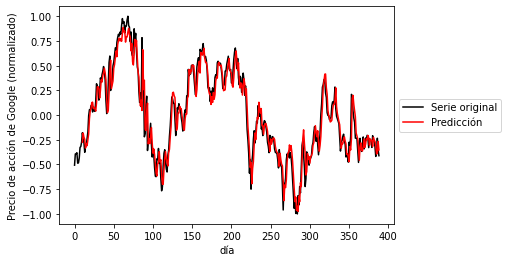

In [ ]:
window_size = 10
X_google, y_google = window_transform_series(google_price_scaled,window_size)
X_google = np.asarray(np.reshape(X_google, (X_google.shape[0], window_size, 1)))
y_google_predict = model2.predict(X_google)

google_error = model2.evaluate(X_google, y_google, verbose=0)
print('Error de test = ' + str(google_error))

import matplotlib.pyplot as plt
%matplotlib inline

# Graficar serie original
plt.plot(google_price_scaled,color = 'k')
plt.plot(np.arange(window_size,len(google_price_scaled),1),y_google_predict, color='r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Google (normalizado)')
plt.legend(['Serie original','Predicción'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()